In [2]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from keras.metrics import MeanIoU
from keras.models import *
import keras.utils
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import *
from simple_multi_unet_model import multi_unet_model,jacard_coef
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2022-04-14 11:01:14.964031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 11:01:14.964108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [3]:
scaler = MinMaxScaler()

root_directory = '/home/jagan/Desktop/ML INTERNSHIP/Semantic segmentation dataset/TEMP/'

patch_size = 256

image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path) 
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):
               
                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)             
       
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        single_patch_img = single_patch_img[0]                               
                        image_dataset.append(single_patch_img)
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks': 
        masks = os.listdir(path)
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):
               
                mask = cv2.imread(path+"/"+mask_name, 1)  
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                              
                        mask_dataset.append(single_patch_mask)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)



Now patchifying image: /home/jagan/Desktop/ML INTERNSHIP/Semantic segmentation dataset/TEMP/images/image_part_001.jpg
Now patchifying mask: /home/jagan/Desktop/ML INTERNSHIP/Semantic segmentation dataset/TEMP/masks/image_part_001.png


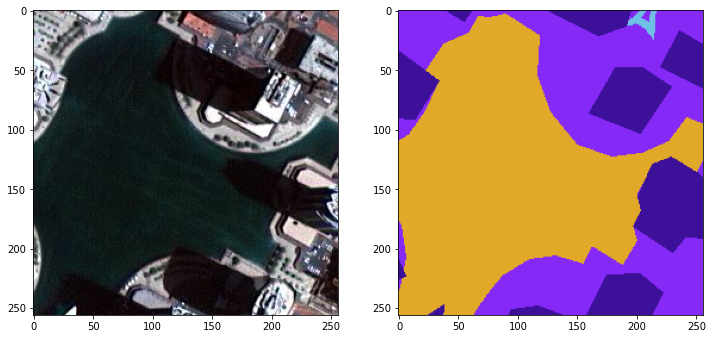

60


In [4]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

a=int('3C', 16)
print(a)
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask


In [5]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]
    
    return label_seg


In [6]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

In [7]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4]


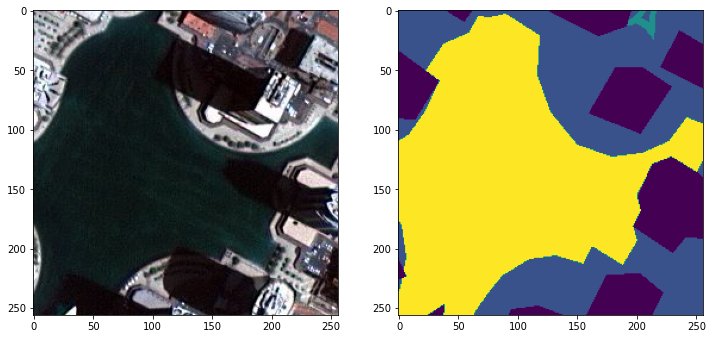

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [9]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [10]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [11]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()
print("DONE HERE")

2022-04-14 11:01:41.767930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 11:01:41.769305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 11:01:41.769637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-14 11:01:41.769944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-14 11:01:41.770243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [12]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
print("DONE HERE")

Epoch 1/100


2022-04-14 11:01:50.730840: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2022-04-14 11:01:51.698173: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2022-04-14 11:01:51.698267: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2022-04-14 11:01:51.698428: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


1/1 [==============================] - 13s 13s/step - loss: 2.6162 - accuracy: 0.1843 - jacard_coef: 0.0887 - val_loss: 1.8674 - val_accuracy: 0.1948 - val_jacard_coef: 0.1019
Epoch 2/100


2022-04-14 11:01:58.317762: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


1/1 [==============================] - 5s 5s/step - loss: 2.0291 - accuracy: 0.2305 - jacard_coef: 0.0977 - val_loss: 1.7385 - val_accuracy: 0.1960 - val_jacard_coef: 0.1058
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 1.8272 - accuracy: 0.2443 - jacard_coef: 0.1031 - val_loss: 1.6673 - val_accuracy: 0.1973 - val_jacard_coef: 0.1091
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.7207 - accuracy: 0.2505 - jacard_coef: 0.1074 - val_loss: 1.6219 - val_accuracy: 0.2001 - val_jacard_coef: 0.1119
Epoch 5/100
1/1 [==============================] - 6s 6s/step - loss: 1.6560 - accuracy: 0.2545 - jacard_coef: 0.1108 - val_loss: 1.5962 - val_accuracy: 0.2042 - val_jacard_coef: 0.1139
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 1.6171 - accuracy: 0.2593 - jacard_coef: 0.1133 - val_loss: 1.5837 - val_accuracy: 0.2060 - val_jacard_coef: 0.1149
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 1.5928 - acc

Epoch 46/100
1/1 [==============================] - 4s 4s/step - loss: 1.2305 - accuracy: 0.3543 - jacard_coef: 0.1976 - val_loss: 1.4297 - val_accuracy: 0.2864 - val_jacard_coef: 0.1704
Epoch 47/100
1/1 [==============================] - 4s 4s/step - loss: 1.2253 - accuracy: 0.3556 - jacard_coef: 0.1986 - val_loss: 1.4251 - val_accuracy: 0.2884 - val_jacard_coef: 0.1690
Epoch 48/100
1/1 [==============================] - 4s 4s/step - loss: 1.2208 - accuracy: 0.3556 - jacard_coef: 0.1970 - val_loss: 1.4212 - val_accuracy: 0.2915 - val_jacard_coef: 0.1672
Epoch 49/100
1/1 [==============================] - 4s 4s/step - loss: 1.2181 - accuracy: 0.3566 - jacard_coef: 0.1949 - val_loss: 1.4331 - val_accuracy: 0.2963 - val_jacard_coef: 0.1665
Epoch 50/100
1/1 [==============================] - 4s 4s/step - loss: 1.2170 - accuracy: 0.3572 - jacard_coef: 0.1946 - val_loss: 1.4703 - val_accuracy: 0.3058 - val_jacard_coef: 0.1671
Epoch 51/100
1/1 [==============================] - 4s 4s/step - 

Epoch 90/100
1/1 [==============================] - 4s 4s/step - loss: 1.1244 - accuracy: 0.4242 - jacard_coef: 0.2169 - val_loss: 1.3947 - val_accuracy: 0.3822 - val_jacard_coef: 0.1790
Epoch 91/100
1/1 [==============================] - 4s 4s/step - loss: 1.1300 - accuracy: 0.4249 - jacard_coef: 0.2156 - val_loss: 1.3988 - val_accuracy: 0.3899 - val_jacard_coef: 0.1832
Epoch 92/100
1/1 [==============================] - 4s 4s/step - loss: 1.1160 - accuracy: 0.4301 - jacard_coef: 0.2187 - val_loss: 1.4059 - val_accuracy: 0.4038 - val_jacard_coef: 0.1867
Epoch 93/100
1/1 [==============================] - 4s 4s/step - loss: 1.1221 - accuracy: 0.4309 - jacard_coef: 0.2185 - val_loss: 1.3842 - val_accuracy: 0.3902 - val_jacard_coef: 0.1828
Epoch 94/100
1/1 [==============================] - 8s 8s/step - loss: 1.1117 - accuracy: 0.4415 - jacard_coef: 0.2203 - val_loss: 1.3798 - val_accuracy: 0.3923 - val_jacard_coef: 0.1835
Epoch 95/100
1/1 [==============================] - 4s 4s/step - 

In [13]:
model.save('models/satellite_standard_unet.hdf5')

In [14]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [15]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [16]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [17]:
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [18]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))
print("Done Here")

Epoch 1/100
1/1 [==============================] - 50s 50s/step - loss: 1.9393 - accuracy: 0.2883 - jacard_coef: 0.1319 - val_loss: 1.7421 - val_accuracy: 0.1865 - val_jacard_coef: 0.1065
Epoch 2/100
1/1 [==============================] - 8s 8s/step - loss: 1.6287 - accuracy: 0.3159 - jacard_coef: 0.1449 - val_loss: 3.6166 - val_accuracy: 0.0199 - val_jacard_coef: 0.0483
Epoch 3/100
1/1 [==============================] - 16s 16s/step - loss: 1.4345 - accuracy: 0.3662 - jacard_coef: 0.1633 - val_loss: 9.6968 - val_accuracy: 0.0076 - val_jacard_coef: 0.0109
Epoch 4/100
1/1 [==============================] - 16s 16s/step - loss: 1.3161 - accuracy: 0.4113 - jacard_coef: 0.1796 - val_loss: 9.3696 - val_accuracy: 0.0092 - val_jacard_coef: 0.0101
Epoch 5/100
1/1 [==============================] - 11s 11s/step - loss: 1.1937 - accuracy: 0.4642 - jacard_coef: 0.2057 - val_loss: 7.1517 - val_accuracy: 0.0526 - val_jacard_coef: 0.0455
Epoch 6/100
1/1 [==============================] - 8s 8s/step 

Epoch 45/100
1/1 [==============================] - 8s 8s/step - loss: 0.1119 - accuracy: 0.9695 - jacard_coef: 0.8522 - val_loss: 2.0667 - val_accuracy: 0.2008 - val_jacard_coef: 0.1199
Epoch 46/100
1/1 [==============================] - 8s 8s/step - loss: 0.1052 - accuracy: 0.9719 - jacard_coef: 0.8582 - val_loss: 2.0837 - val_accuracy: 0.2031 - val_jacard_coef: 0.1182
Epoch 47/100
1/1 [==============================] - 8s 8s/step - loss: 0.1035 - accuracy: 0.9717 - jacard_coef: 0.8610 - val_loss: 1.9723 - val_accuracy: 0.2073 - val_jacard_coef: 0.1195
Epoch 48/100
1/1 [==============================] - 8s 8s/step - loss: 0.1001 - accuracy: 0.9730 - jacard_coef: 0.8651 - val_loss: 1.8997 - val_accuracy: 0.2122 - val_jacard_coef: 0.1192
Epoch 49/100
1/1 [==============================] - 8s 8s/step - loss: 0.0956 - accuracy: 0.9750 - jacard_coef: 0.8700 - val_loss: 1.8892 - val_accuracy: 0.2173 - val_jacard_coef: 0.1183
Epoch 50/100
1/1 [==============================] - 9s 9s/step - 

Epoch 89/100
1/1 [==============================] - 8s 8s/step - loss: 0.0431 - accuracy: 0.9900 - jacard_coef: 0.9350 - val_loss: 1.8064 - val_accuracy: 0.1985 - val_jacard_coef: 0.1221
Epoch 90/100
1/1 [==============================] - 8s 8s/step - loss: 0.0425 - accuracy: 0.9904 - jacard_coef: 0.9359 - val_loss: 1.7975 - val_accuracy: 0.1986 - val_jacard_coef: 0.1224
Epoch 91/100
1/1 [==============================] - 7s 7s/step - loss: 0.0416 - accuracy: 0.9907 - jacard_coef: 0.9369 - val_loss: 1.8111 - val_accuracy: 0.1980 - val_jacard_coef: 0.1224
Epoch 92/100
1/1 [==============================] - 8s 8s/step - loss: 0.0411 - accuracy: 0.9908 - jacard_coef: 0.9378 - val_loss: 1.8173 - val_accuracy: 0.1979 - val_jacard_coef: 0.1227
Epoch 93/100
1/1 [==============================] - 7s 7s/step - loss: 0.0404 - accuracy: 0.9910 - jacard_coef: 0.9386 - val_loss: 1.8153 - val_accuracy: 0.1978 - val_jacard_coef: 0.1231
Epoch 94/100
1/1 [==============================] - 8s 8s/step - 

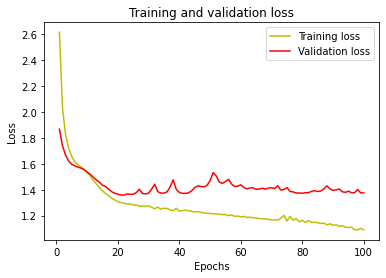

In [19]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

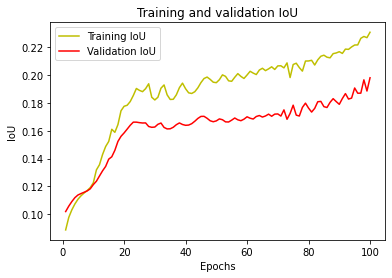

In [20]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [21]:
model = load_model("models/satellite_standard_unet.hdf5",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

In [22]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [23]:
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.22657114


In [24]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

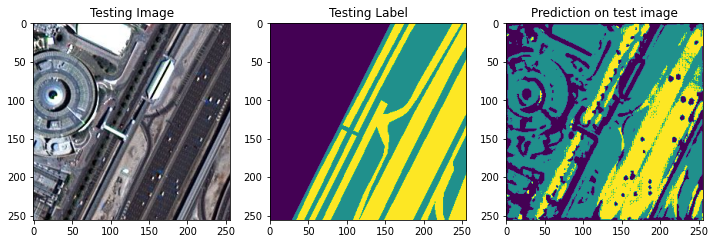

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()